In [1]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch()

if not(es.indices.exists(index="tp5-championstweet")):
    res = es.indices.create(index="tp5-championstweet")  
    pprint(res)

In [2]:
#LISTAR LOS ARCHIVOS DEL DATASET
import json
import os
files = os.listdir("split_dataset_1")
pprint(len(files))

354585


from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('split_dataset_1/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            timestamp=int(tweet["timestamp_ms"])
            #pprint(tweet)
            simple_tweet = {
                "timestamp":timestamp, \
                "date":tweet["created_at"], \
               "text": tweet['text'], \
               "username": tweet['user']['name'], \
               "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)#remove comment
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="tp5-championstweet", doc_type="_doc")
        tweets=[]

#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body={"query": {"match_all": {}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])
    print(hit)

In [3]:
res = es.search(index="tp5-championstweet", body={"query":{"match":{"text":"goal" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
pprint(res)


{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'aggregations': {'tweets_over_time': {'buckets': [{'doc_count': 6,
                                                    'key': 1527340680000},
                                                   {'doc_count': 0,
                                                    'key': 1527340740000},
                                                   {'doc_count': 0,
                                                    'key': 1527340800000},
                                                   {'doc_count': 0,
                                                    'key': 1527340860000},
                                                   {'doc_count': 0,
                                                    'key': 1527340920000},
                                                   {'doc_count': 0,
                                                    'key': 1527340980000},
                                                   {'doc_count': 0,
    

                                                   {'doc_count': 0,
                                                    'key': 1527358260000},
                                                   {'doc_count': 0,
                                                    'key': 1527358320000},
                                                   {'doc_count': 0,
                                                    'key': 1527358380000},
                                                   {'doc_count': 0,
                                                    'key': 1527358440000},
                                                   {'doc_count': 0,
                                                    'key': 1527358500000},
                                                   {'doc_count': 0,
                                                    'key': 1527358560000},
                                                   {'doc_count': 0,
                                                    'key': 1527358620000},

In [4]:
res2 = es.search(index="tp5-championstweet", body={"query":{"match":{"text":"goal" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "10m" \
                                                                                 }}}})
pprint(res2)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'aggregations': {'tweets_over_time': {'buckets': [{'doc_count': 6,
                                                    'key': 1527340200000},
                                                   {'doc_count': 0,
                                                    'key': 1527340800000},
                                                   {'doc_count': 0,
                                                    'key': 1527341400000},
                                                   {'doc_count': 0,
                                                    'key': 1527342000000},
                                                   {'doc_count': 0,
                                                    'key': 1527342600000},
                                                   {'doc_count': 0,
                                                    'key': 1527343200000},
                                                   {'doc_count': 0,
    

In [5]:
import pandas as pd

df_tweetsByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_tweetsByMinutes = df_tweetsByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df_tweetsByMinutes[:10]

,nb_tweets,timestamp
0,6,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000
5,0,1527340980000
6,0,1527341040000
7,0,1527341100000
8,0,1527341160000
9,0,1527341220000


In [6]:
df_tweetsByMinutes_filtered = df_tweetsByMinutes.drop(df_tweetsByMinutes[df_tweetsByMinutes.timestamp < 1527357600000 ].index)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,1527357600000
283,0,1527357660000
284,0,1527357720000
285,0,1527357780000
286,0,1527357840000
287,0,1527357900000
288,0,1527357960000
289,0,1527358020000
290,0,1527358080000
291,0,1527358140000


In [7]:
import datetime

def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

df_tweetsByMinutes_filtered['timestamp']=df_tweetsByMinutes_filtered['timestamp'].apply(timestamp2date)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,14:00:00
283,0,14:01:00
284,0,14:02:00
285,0,14:03:00
286,0,14:04:00
287,0,14:05:00
288,0,14:06:00
289,0,14:07:00
290,0,14:08:00
291,0,14:09:00


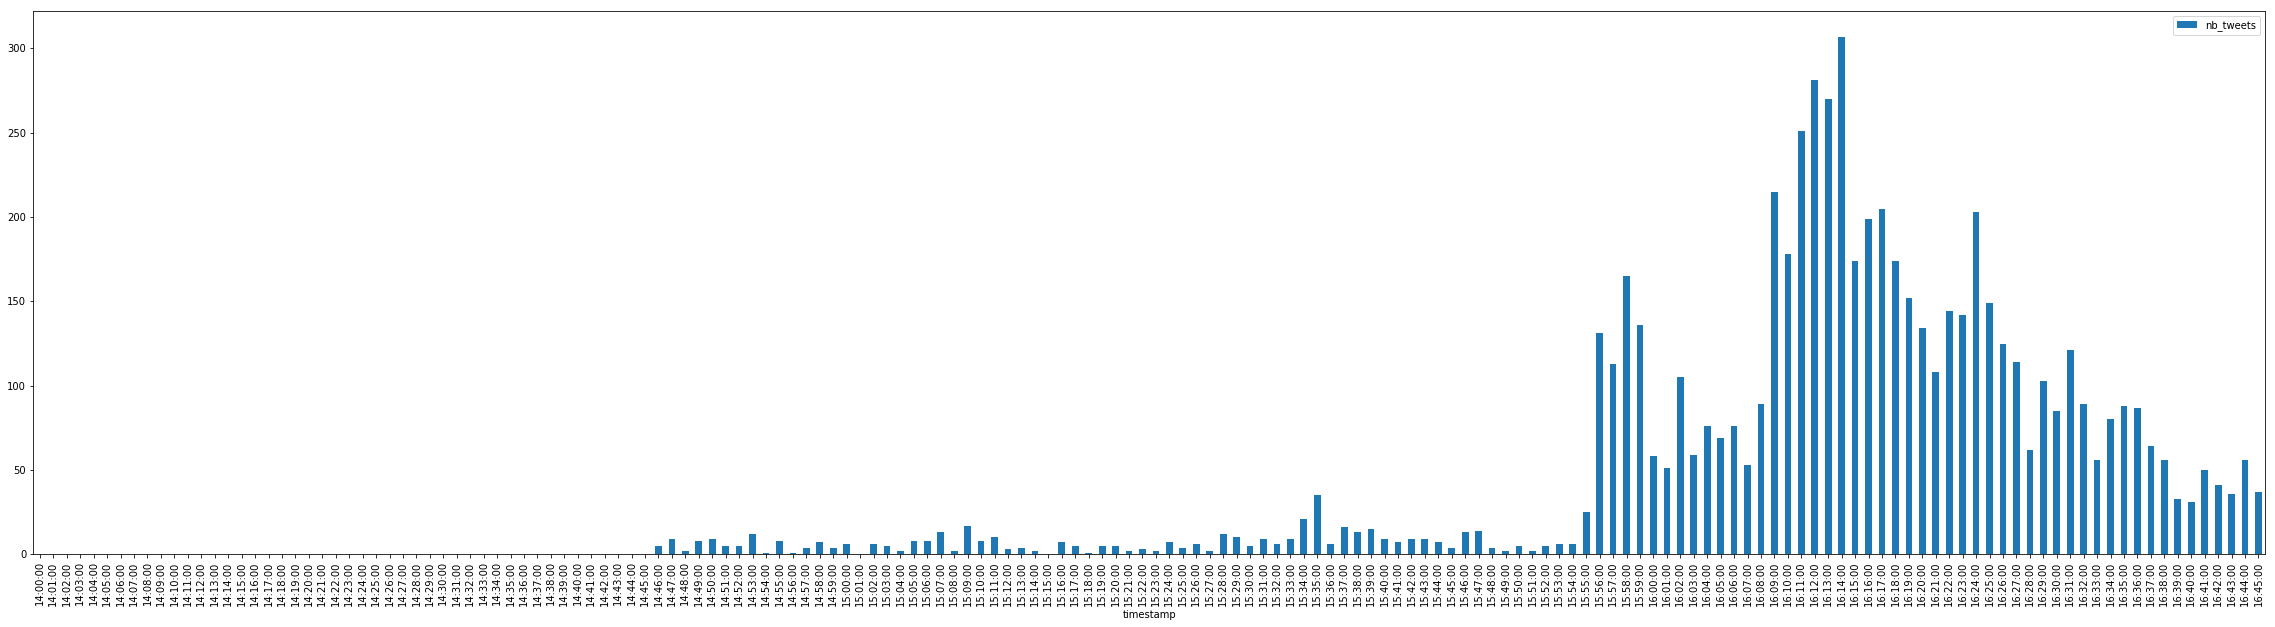

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

df_tweetsByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

In [9]:
df_tweetsByMinutes2 = pd.DataFrame(res2['aggregations']['tweets_over_time']['buckets'])
df_tweetsByMinutes2 = df_tweetsByMinutes2.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df_tweetsByMinutes2[:10]

,nb_tweets,timestamp
0,6,1527340200000
1,0,1527340800000
2,0,1527341400000
3,0,1527342000000
4,0,1527342600000
5,0,1527343200000
6,0,1527343800000
7,0,1527344400000
8,0,1527345000000
9,0,1527345600000


In [10]:
df_tweetsByMinutes_filtered2 = df_tweetsByMinutes2.drop(df_tweetsByMinutes2[df_tweetsByMinutes2.timestamp < 1527357600000 ].index)
df_tweetsByMinutes_filtered2[:10]

,nb_tweets,timestamp
29,0,1527357600000
30,0,1527358200000
31,0,1527358800000
32,0,1527359400000
33,24,1527360000000
34,56,1527360600000
35,67,1527361200000
36,45,1527361800000
37,53,1527362400000
38,135,1527363000000


In [11]:
def timestamp2date2(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

df_tweetsByMinutes_filtered2['timestamp']=df_tweetsByMinutes_filtered2['timestamp'].apply(timestamp2date2)
df_tweetsByMinutes_filtered2[:10]

,nb_tweets,timestamp
29,0,14:00:00
30,0,14:10:00
31,0,14:20:00
32,0,14:30:00
33,24,14:40:00
34,56,14:50:00
35,67,15:00:00
36,45,15:10:00
37,53,15:20:00
38,135,15:30:00


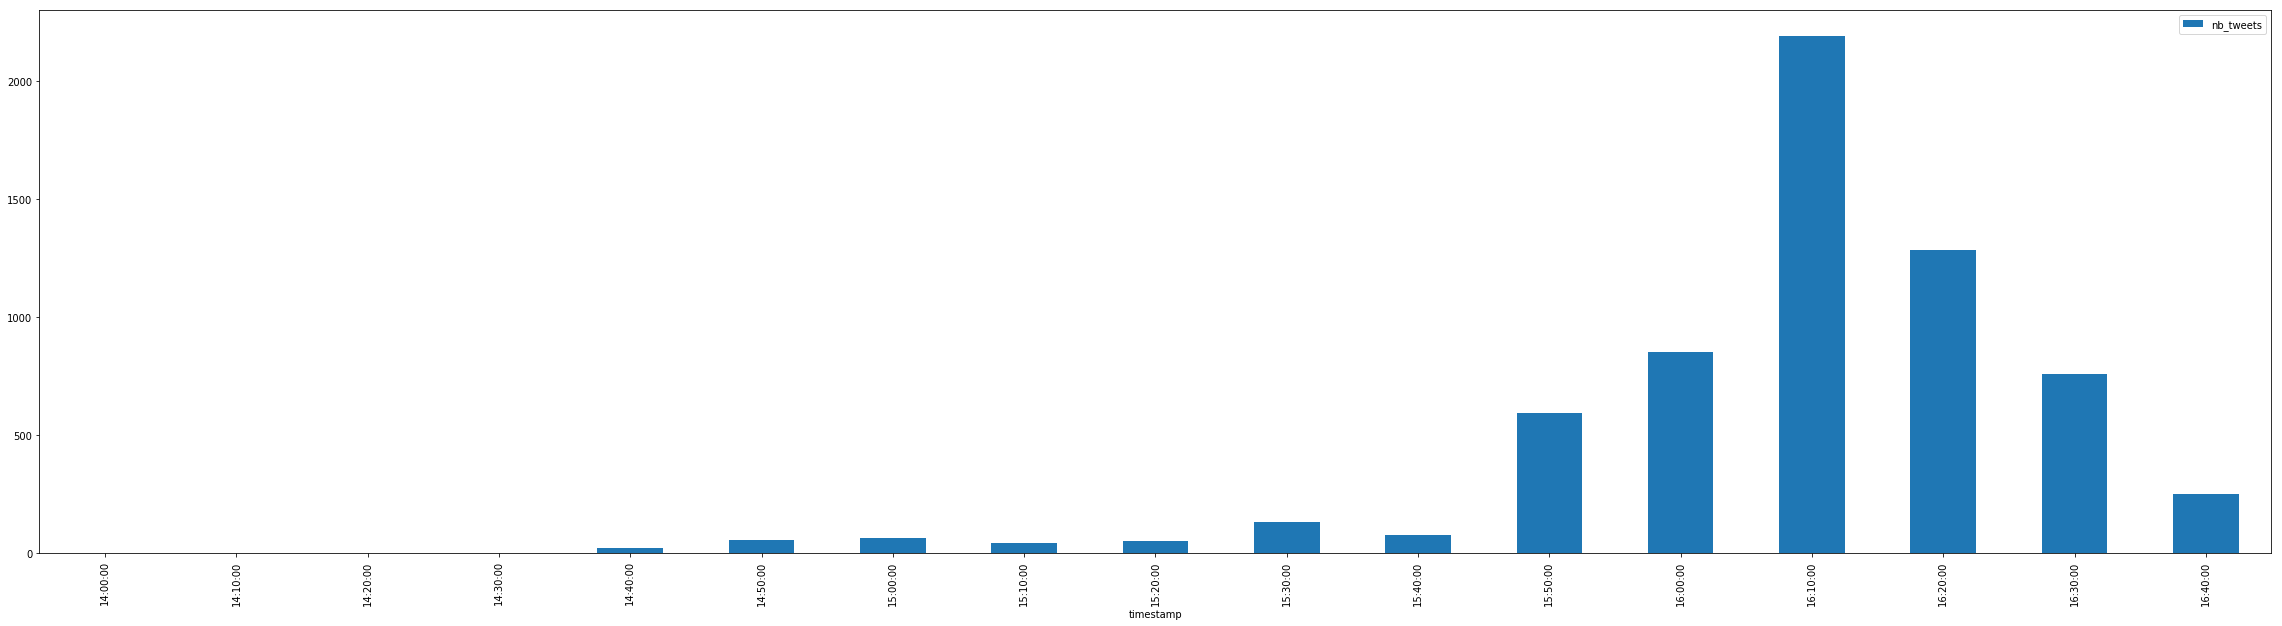

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

df_tweetsByMinutes_filtered2.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

In [42]:
liverpool = es.search(index="tp5-championstweet", body={"query":{"match":{"text":"liverpool" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
madrid = es.search(index="tp5-championstweet", body={"query":{"match":{"text":"madrid" }},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
pprint(liverpool)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'aggregations': {'tweets_over_time': {'buckets': [{'doc_count': 9,
                                                    'key': 1527340680000},
                                                   {'doc_count': 0,
                                                    'key': 1527340740000},
                                                   {'doc_count': 0,
                                                    'key': 1527340800000},
                                                   {'doc_count': 0,
                                                    'key': 1527340860000},
                                                   {'doc_count': 0,
                                                    'key': 1527340920000},
                                                   {'doc_count': 0,
                                                    'key': 1527340980000},
                                                   {'doc_count': 0,
    

                                                    'key': 1527355140000},
                                                   {'doc_count': 0,
                                                    'key': 1527355200000},
                                                   {'doc_count': 0,
                                                    'key': 1527355260000},
                                                   {'doc_count': 0,
                                                    'key': 1527355320000},
                                                   {'doc_count': 0,
                                                    'key': 1527355380000},
                                                   {'doc_count': 0,
                                                    'key': 1527355440000},
                                                   {'doc_count': 0,
                                                    'key': 1527355500000},
                                                   {'doc_count': 0,

                                                    'key': 1527367140000},
                                                   {'doc_count': 205,
                                                    'key': 1527367200000},
                                                   {'doc_count': 195,
                                                    'key': 1527367260000},
                                                   {'doc_count': 154,
                                                    'key': 1527367320000},
                                                   {'doc_count': 122,
                                                    'key': 1527367380000},
                                                   {'doc_count': 146,
                                                    'key': 1527367440000},
                                                   {'doc_count': 134,
                                                    'key': 1527367500000}]}},
 'hits': {'hits': [{'_id': 'uOUvgWQBEmehqEuV8e7C',
 

In [64]:
for i in range (0,10):
    #print(liverpool['hits']['hits'][i]['_source']['text'])
    print(madrid['hits']['hits'][i]['_source']['text'])

Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
 #UCLfinal
Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
 #UCLfinal
RT @CThelasco: HALA MADRID HALA MADRID HALA MADRID HALA MADRID HALA MADRID HALA MADRID #UCLfinal
RT @DanielMaithyaKE: Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
 #UCLfinal
#Hala…
RT @DanielMaithyaKE: Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
 #UCLfinal
#Hala…
RT @DanielMaithyaKE: Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
 #UCLfinal
#Hala…
RT @DanielMaithyaKE: Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
Hala Madrid
Hala Madrid 
Hala Madrid 
Hala Madrid 
 #UCLfinal
#Hala…
RT @CThelasco: HALA MADRID HALA MADRID HALA MADRID HALA MADRID HALA MADRID HALA MADRID #UCLfinal
Hala Madrid #UCL

In [92]:
liverpool_min = pd.DataFrame(liverpool['aggregations']['tweets_over_time']['buckets'])
liverpool_min = liverpool_min.rename(columns={'key': 'timestamp', 'doc_count': 'num_tw_liverpool'})
#liverpool_min[:10]
#liverpool_min

In [93]:
madrid_min=pd.DataFrame(madrid['aggregations']['tweets_over_time']['buckets'])
madrid_min = madrid_min.rename(columns={'key': 'timestamp', 'doc_count': 'num_tw_madrid'})
#madrid_min[:10]
#madrid_min


In [110]:
result=pd.merge(liverpool_min,madrid_min, on='timestamp')
result

,num_tw_liverpool,timestamp,num_tw_madrid
0,9,1527340680000,9
1,0,1527340740000,0
2,0,1527340800000,0
3,0,1527340860000,0
4,0,1527340920000,0
5,0,1527340980000,0
6,0,1527341040000,0
7,0,1527341100000,0
8,0,1527341160000,0
9,0,1527341220000,0


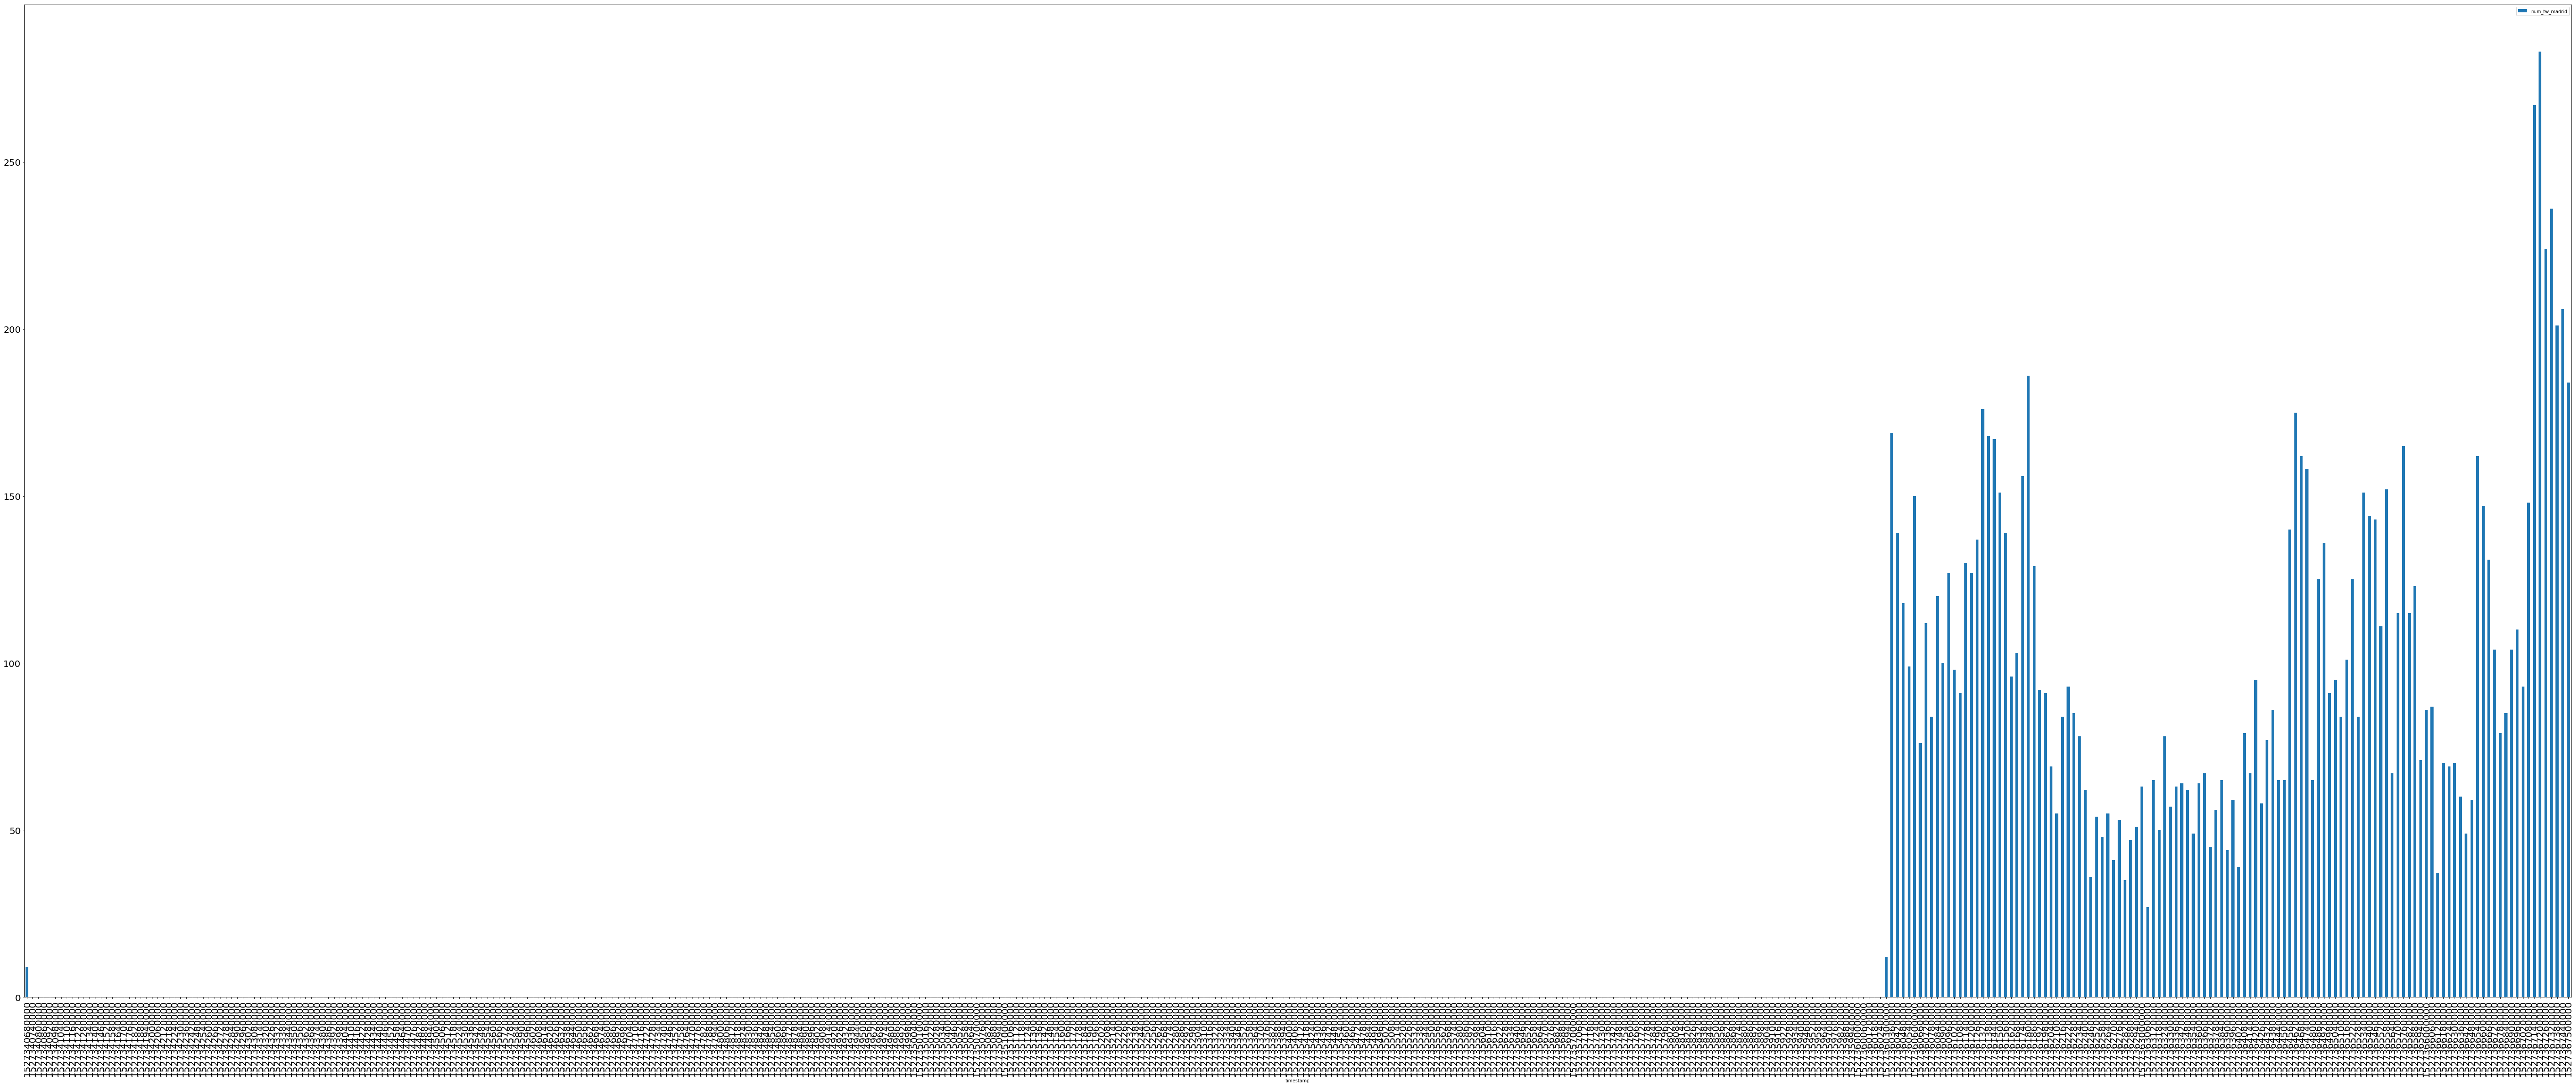

In [111]:
result.plot(kind='bar',figsize=(100,40), fontsize=20, x='timestamp', y=['num_tw_madrid'])
plt.show()
#grafica twits que contienen la palabra madrid

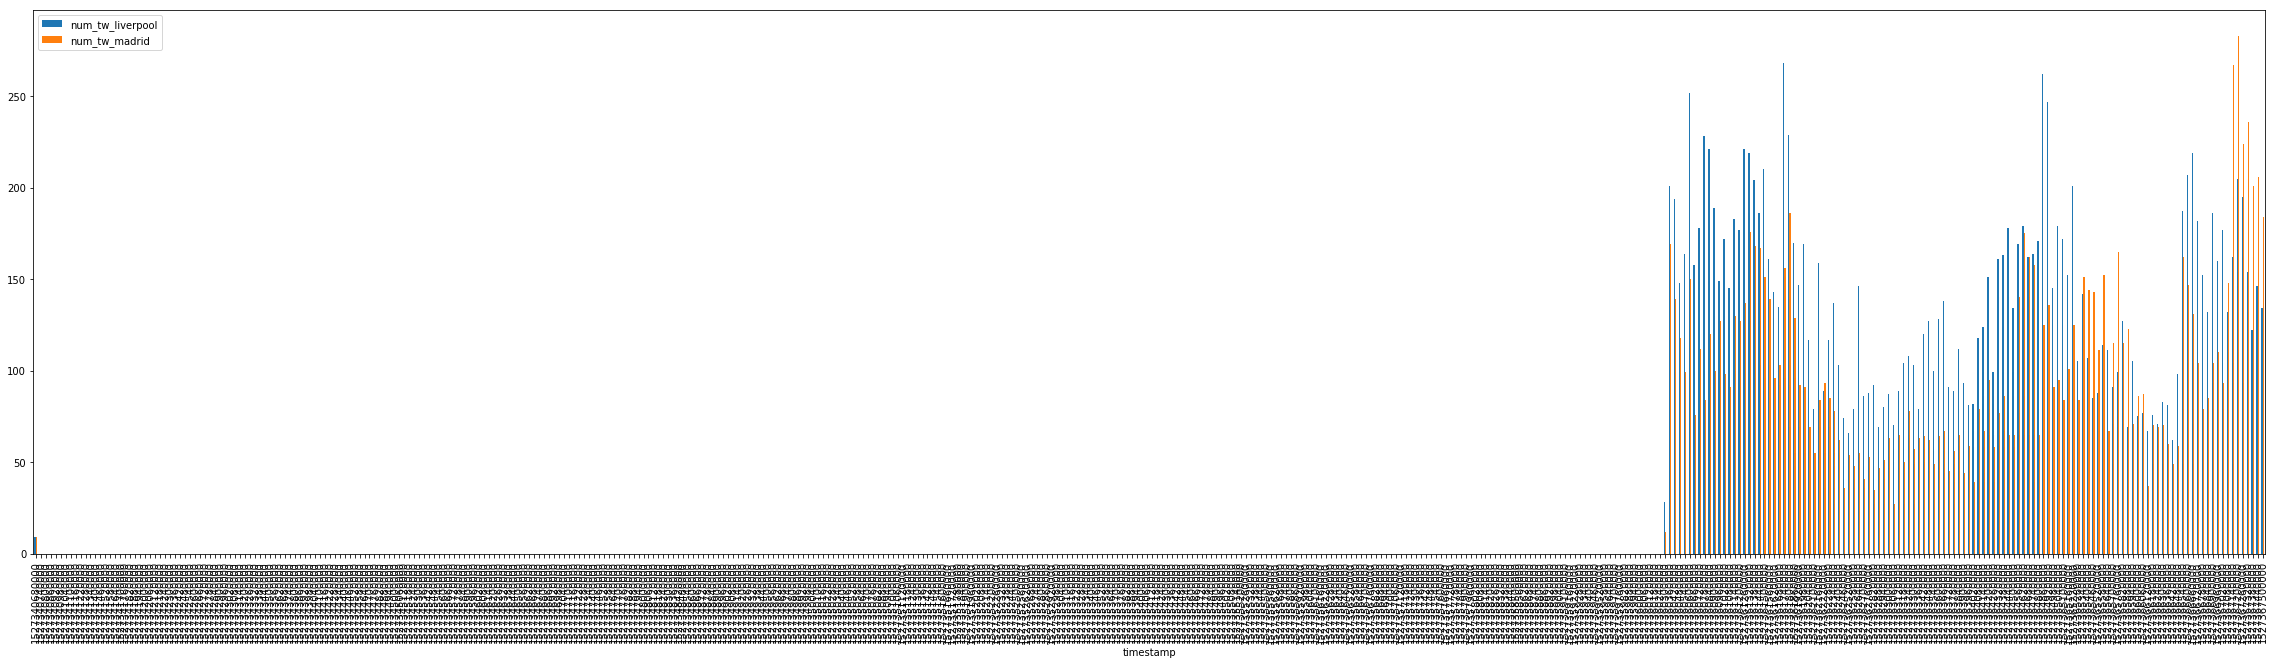

In [112]:
result.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp', y=['num_tw_liverpool','num_tw_madrid'])
plt.show()
#grafica de num liverpool y num madrid

In [151]:
#de acuerdo a la primera grafica el timestamp con mas tuit de madrid es 1527367200000 con 283 tuits

In [150]:
print(result.timestamp[442],result.num_tw_madrid[442])
#print(result.num_tw_madrid[442])
tiempo=result.timestamp[442]
print("¿A qué minuto se habla más de Madrid? --- a las ---  "+timestamp2date(tiempo))

1527367200000 283
¿A qué minuto se habla más de Madrid? --- a las ---  16:40:00


In [236]:
pregunta3 = es.search(index="tp5-championstweet", body={"query":{"match_all":{}}})
pprint(pregunta3)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': 'WeUtgWQBEmehqEuVg7kE',
                    '_index': 'tp5-championstweet',
                    '_score': 1.0,
                    '_source': {'date': 'Sat May 26 18:54:24 +0000 2018',
                                'location': 'Midland, TX',
                                'text': 'RT @SenegalFootball: HALA MANÉ Y NADA '
                                        'MAS!!!!\n'
                                        '\n'
                                        '#UCLfinal #RMALIV',
                                'timestamp': 1527360864662,
                                'username': '❄️ND❄️'},
                    '_type': '_doc'},
                   {'_id': 'W-UtgWQBEmehqEuVg7kE',
                    '_index': 'tp5-championstweet',
                    '_score': 1.0,
                    '_source': {'date': 'Sat May 26 20:44:17 +0000 2018',
                                'location': 'Deutschlan

In [243]:
#pregunta4 = es.search(index="tp5-championstweet", body={"query":{ "_source": {"location"}}})
print(pregunta3['hits']['hits'])

[{'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'WeUtgWQBEmehqEuVg7kE', '_score': 1.0, '_source': {'timestamp': 1527360864662, 'date': 'Sat May 26 18:54:24 +0000 2018', 'text': 'RT @SenegalFootball: HALA MANÉ Y NADA MAS!!!!\n\n#UCLfinal #RMALIV', 'username': '❄️ND❄️', 'location': 'Midland, TX'}}, {'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'W-UtgWQBEmehqEuVg7kE', '_score': 1.0, '_source': {'timestamp': 1527367457819, 'date': 'Sat May 26 20:44:17 +0000 2018', 'text': 'Mir tut #Karius so dermaßen leid. \n\n#UCLfinal #RMALFC', 'username': 'Devious_99', 'location': 'Deutschland'}}, {'_index': 'tp5-championstweet', '_type': '_doc', '_id': 'X-UtgWQBEmehqEuVg7kE', '_score': 1.0, '_source': {'timestamp': 1527363693817, 'date': 'Sat May 26 19:41:33 +0000 2018', 'text': 'RT @ActualidadRT: #UCLfinal Real Madrid – Liverpool \nTermina una primera parte muy igualada en todos los sentidos. Carvajal y Salah se fuer…', 'username': 'tupamaro tachira', 'location': 'TACHIRA - VENEZU

In [ ]:
#para lograr la consulta siguiente tuve que modificaruna propiedad de location, lo hice con esto
#PUT my_index/_mapping/my_type
#{
 # "properties": {
  #  "my_field": { 
   #   "type":     "text",
    #  "fielddata": true
    #}
  #}
#}

In [298]:
pregunta5 = es.search(index="tp5-championstweet", body={
"size": 50,
"aggs" : {
    "_source" : {
        "terms" : { 
            "field" : "location",  "size" : 500 }
    }
}})


In [300]:
prueba5 = es.search(index="tp5-championstweet", body={
  "query": {
    "match_all": {}
  }, 
"size": 0,
"aggs" : {
    "_source" : {
        "terms" : { 
            "field" : "location"}
    }
}}) 


In [301]:
pregunta5

{'took': 52,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 134000,
  'max_score': 1.0,
  'hits': [{'_index': 'tp5-championstweet',
    '_type': '_doc',
    '_id': 'WeUtgWQBEmehqEuVg7kE',
    '_score': 1.0,
    '_source': {'timestamp': 1527360864662,
     'date': 'Sat May 26 18:54:24 +0000 2018',
     'text': 'RT @SenegalFootball: HALA MANÉ Y NADA MAS!!!!\n\n#UCLfinal #RMALIV',
     'username': '❄️ND❄️',
     'location': 'Midland, TX'}},
   {'_index': 'tp5-championstweet',
    '_type': '_doc',
    '_id': 'W-UtgWQBEmehqEuVg7kE',
    '_score': 1.0,
    '_source': {'timestamp': 1527367457819,
     'date': 'Sat May 26 20:44:17 +0000 2018',
     'text': 'Mir tut #Karius so dermaßen leid. \n\n#UCLfinal #RMALFC',
     'username': 'Devious_99',
     'location': 'Deutschland'}},
   {'_index': 'tp5-championstweet',
    '_type': '_doc',
    '_id': 'X-UtgWQBEmehqEuVg7kE',
    '_score': 1.0,
    '_source': {'timestamp': 1527363693817,
 

In [295]:
prueba5

{'took': 231,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 134000,
  'max_score': 1.0,
  'hits': [{'_index': 'tp5-championstweet',
    '_type': '_doc',
    '_id': 'WeUtgWQBEmehqEuVg7kE',
    '_score': 1.0,
    '_source': {'timestamp': 1527360864662,
     'date': 'Sat May 26 18:54:24 +0000 2018',
     'text': 'RT @SenegalFootball: HALA MANÉ Y NADA MAS!!!!\n\n#UCLfinal #RMALIV',
     'username': '❄️ND❄️',
     'location': 'Midland, TX'}},
   {'_index': 'tp5-championstweet',
    '_type': '_doc',
    '_id': 'W-UtgWQBEmehqEuVg7kE',
    '_score': 1.0,
    '_source': {'timestamp': 1527367457819,
     'date': 'Sat May 26 20:44:17 +0000 2018',
     'text': 'Mir tut #Karius so dermaßen leid. \n\n#UCLfinal #RMALFC',
     'username': 'Devious_99',
     'location': 'Deutschland'}},
   {'_index': 'tp5-championstweet',
    '_type': '_doc',
    '_id': 'X-UtgWQBEmehqEuVg7kE',
    '_score': 1.0,
    '_source': {'timestamp': 1527363693817,


In [250]:
datapregunta5=pd.DataFrame(pregunta5['aggregations']['_source']['buckets'])

In [251]:
datapregunta5

,doc_count,key
0,4432,nigeria
1,3878,south
2,3701,africa
3,3394,england
4,2491,de
5,2480,brasil
6,2266,lagos
7,2080,london
8,1697,españa
9,1536,kenya


In [268]:
preg4= es.search(index="tp5-championstweet", body={
  "query":{
    "match_phrase_prefix":{
      "location": "inglaterra"
    }
  },
  "aggs" : { 
    "tweets_over_time" :{ 
      "date_histogram" : { 
        "field" : "timestamp", "interval" : "1m"
        }
      }
  }  
})

In [269]:
preg42=es.search(index="tp5-championstweet", body={
  "query":{
    "match_phrase_prefix":{
      "location": "españa"
    }
  },
  "aggs" : { 
    "tweets_over_time" :{ 
      "date_histogram" : { 
        "field" : "timestamp", "interval" : "1m"
        }
      }
  }  
})

In [270]:
preg4=pd.DataFrame(preg4['aggregations']['tweets_over_time']['buckets'])
preg4 = preg4.rename(columns={'key': 'timestamp', 'doc_count': 'num_inglaterra'})

In [271]:
preg42=pd.DataFrame(preg42['aggregations']['tweets_over_time']['buckets'])
preg42 = preg42.rename(columns={'key': 'timestamp', 'doc_count': 'num_españa'})

In [272]:
preg4

,num_inglaterra,timestamp
0,4,1527361140000
1,0,1527361200000
2,0,1527361260000
3,0,1527361320000
4,0,1527361380000
5,0,1527361440000
6,0,1527361500000
7,0,1527361560000
8,0,1527361620000
9,0,1527361680000


In [273]:
preg42

,num_españa,timestamp
0,13,1527360360000
1,14,1527360420000
2,20,1527360480000
3,7,1527360540000
4,4,1527360600000
5,16,1527360660000
6,15,1527360720000
7,14,1527360780000
8,15,1527360840000
9,7,1527360900000


In [274]:
r4=pd.merge(preg4,preg42, on='timestamp')

In [275]:
r4

,num_inglaterra,timestamp,num_españa
0,4,1527361140000,11
1,0,1527361200000,17
2,0,1527361260000,20
3,0,1527361320000,12
4,0,1527361380000,7
5,0,1527361440000,5
6,0,1527361500000,5
7,0,1527361560000,6
8,0,1527361620000,4
9,0,1527361680000,17


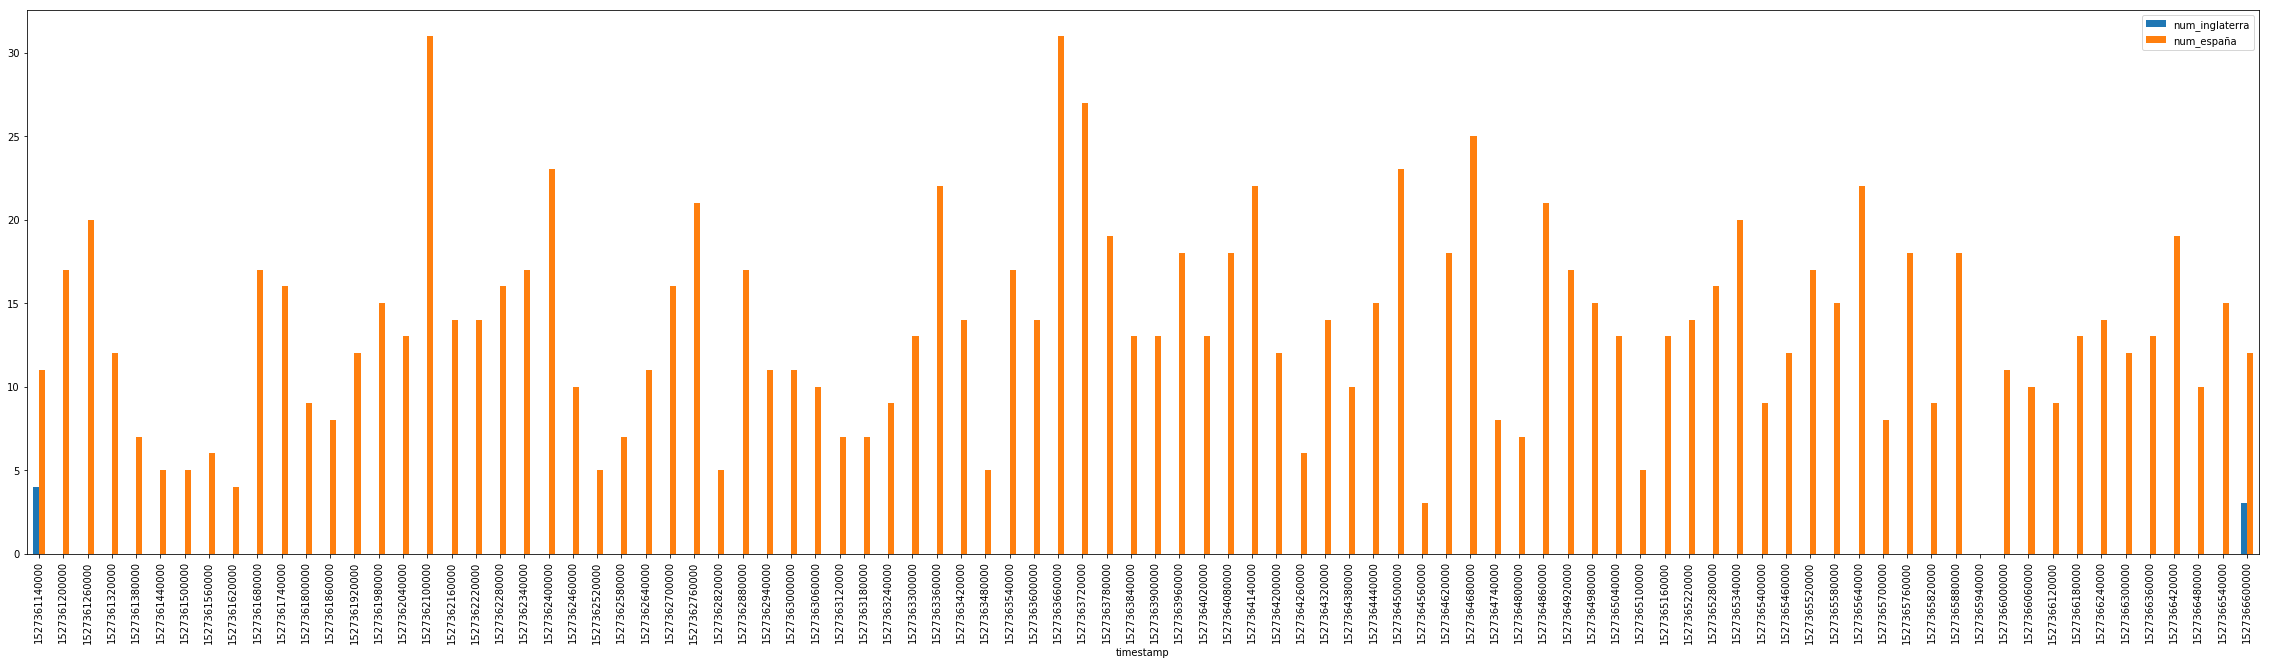

In [276]:
r4.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp', y=['num_inglaterra','num_españa'])
plt.show()

 5) ¿Cómo podríamos analizar las emociones expresadas durante el partido? Proponer una metodología para responder a esta pregunta. (No es obligatorio implementar su metodología pero debe ser factible con las tecnologías que conocen). 
 
Se podria determinar algunas emociones tales como el enojo, la euforia, a partir del texto del tuit. si este esta escrito en mayuscula y si tambien lleva muchos signos de exclamación.
incluso tambien ver si contienen palabras claves(insultos, expresiones de afecto)